# Section 1 – Data exploration and pre-processing

Preprocessing:

In [5]:
!pip install pyarrow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates # to format dates on plots
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import base64
import re
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
def decode_base64(word):
    try:
        return base64.b64decode(word).decode()
    except:
        pass

with open("commands.txt", "r") as f:
    vocabulary = f.read().splitlines()


def split_by_vocabulary(string):
    pattern = '|'.join(map(re.escape, vocabulary))
    matches = re.findall(pattern, string)
    return matches


def decode_session(full_session):
    new_full_session = []
    
    for session_chunk in full_session.split(";"):
        if "base64 --decode" in session_chunk and "echo" in session_chunk:
            parts = session_chunk.split()
            base64_encoded = None
        
            for i in range(len(parts)):
                if parts[i] == "echo":
                    base64_encoded = parts[i + 1].strip("\"")
                    break
            
            if base64_encoded:
                decoded = decode_base64(base64_encoded)
                if decoded:
                    words_decoded = decoded.split("\n")
                    # Remove shebang if present
                    if words_decoded[0].strip() == "#!/bin/bash":
                        words_decoded[0] = ""
                    new_full_session.append("; ".join(list(filter(None, words_decoded))).strip())
                else:
                    new_full_session.append(session_chunk.strip())
            else:
                new_full_session.append(session_chunk.strip())
        else:
            new_full_session.append(session_chunk.strip())
    
    return "; ".join(new_full_session)

In [22]:
df_original = pd.read_parquet('ssh_attacks.parquet')
df_decoded = df_original.copy()
df_decoded['first_timestamp'] = pd.to_datetime(df_decoded['first_timestamp'])
df_decoded["full_session"] = df_decoded["full_session"].apply(lambda session: decode_session(session))
df_decoded.to_parquet("ssh_attacks_decoded.parquet")


In [ ]:
df_decoded_splitted = df_decoded.copy()
df_decoded_splitted["full_session"] = df_decoded_splitted["full_session"].apply(lambda session: split_by_vocabulary(session))
df_decoded_splitted.to_parquet("ssh_attacks_decoded_split.parquet")

df = pd.read_parquet("ssh_attacks_decoded_split.parquet") # df in which full_session contains lists of words

### 1.1 Temporal Series:

Monthly distribution of attacks:

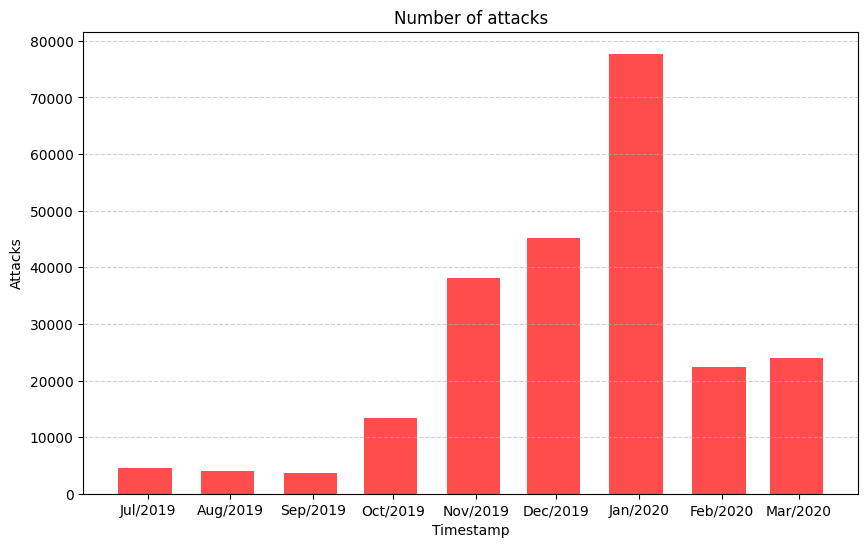

In [3]:
df_copy = df.copy()
df_copy['first_timestamp'] = pd.to_datetime(df_copy['first_timestamp'])
df_copy.set_index('first_timestamp', inplace=True)
df_result = df_copy.resample('ME').size().reset_index(name='count')
df_result

plt.figure(figsize=(10, 6))
# for each month, count the number of rows, that are the number of packets
plt.bar(df_result['first_timestamp'], df_result['count'], alpha=0.7, width=20, color='r')
# Format x-axis to show month/year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xlabel('Timestamp')
plt.ylabel('Attacks')
plt.title(f'Number of attacks')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Daily distribution of attacks:

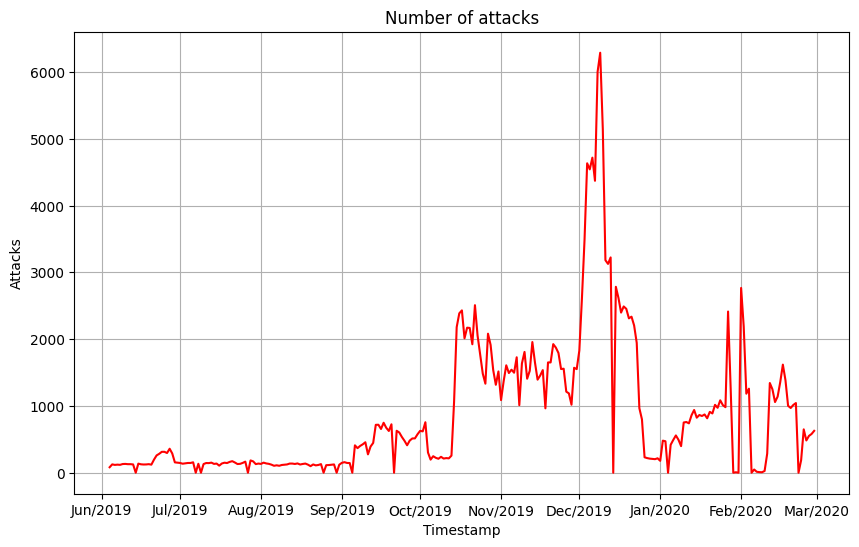

In [4]:
df_copy = df.copy()
df_copy['first_timestamp'] = pd.to_datetime(df_copy['first_timestamp'])
df_copy.set_index('first_timestamp', inplace=True)
df_daily = df_copy.resample('D').size().reset_index(name='count')
df_daily

plt.figure(figsize=(10, 6))
# for each day, count the number of rows, that are the number of packets
plt.plot(df_daily['first_timestamp'], df_daily['count'], linestyle='-', color='r')
# Format x-axis to show month/year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xlabel('Timestamp')
plt.ylabel('Attacks')
plt.title(f'Number of attacks')
plt.grid()
plt.show()

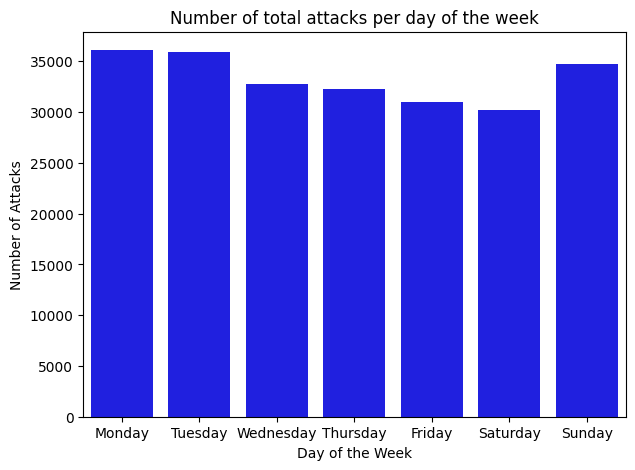

,day_name,count
0,Monday,36106
1,Tuesday,35911
2,Wednesday,32756
3,Thursday,32241
4,Friday,31017
5,Saturday,30238
6,Sunday,34766


In [5]:
df_copy = df.copy()
df_copy['first_timestamp'] = pd.to_datetime(df_copy['first_timestamp'])

# Extract the day of the week (0=Monday, 6=Sunday)
df_copy['day_of_week'] = df_copy['first_timestamp'].dt.dayofweek  # Numeric representation
df_copy['day_name'] = df_copy['first_timestamp'].dt.day_name()   # Full name of the day

# Group by day of the week and count occurrences
df_grouped = df_copy.groupby('day_name').size().reset_index(name='count')

# Ensure the days are ordered from Monday to Sunday
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_grouped['day_name'] = pd.Categorical(df_grouped['day_name'], categories=day_order, ordered=True)
df_grouped = df_grouped.sort_values('day_name').reset_index(drop=True)

plt.figure(figsize=(7,5))
sns.barplot(
    data = df_grouped,
    x = "day_name",
    y = "count",
    color = 'blue'
)

plt.ylabel("Number of Attacks")
plt.xlabel("Day of the Week")
plt.title("Number of total attacks per day of the week")
plt.show()

df_grouped


### 1.2 empirical distribution

In [6]:
n_words = df['full_session'].apply(lambda session: len(session))
n_characters = df['full_session'].apply(lambda session: sum([len(word) for word in session]))
data = pd.DataFrame({"n_characters": n_characters, "n_words": n_words})
data

,n_characters,n_words
0,118,31
1,118,31
2,118,31
3,118,31
4,118,31
...,...,...
233030,204,57
233031,204,57
233032,210,60
233033,204,57


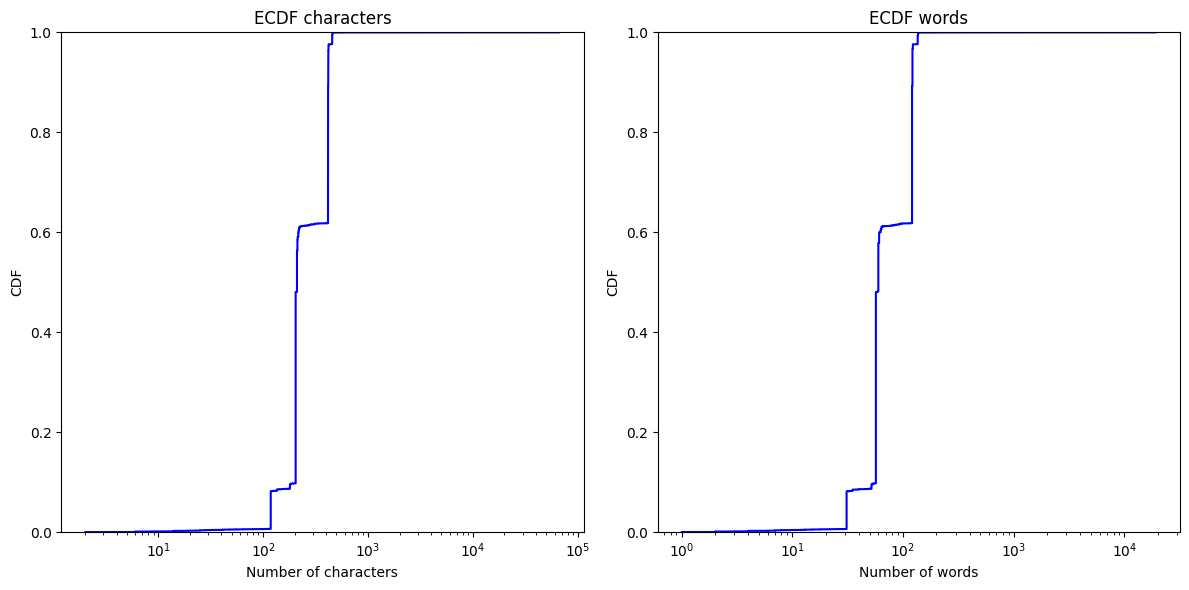

In [7]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.ecdfplot(
    data = data['n_characters'],
    log_scale=True,
    color = 'blue'
)
plt.title("ECDF characters")
plt.xlabel("Number of characters")
plt.ylabel("CDF")

plt.subplot(1,2,2)
sns.ecdfplot(
    data = data['n_words'],
    log_scale=True,
    color = 'blue'
)
plt.title("ECDF words")
plt.xlabel("Number of words")
plt.ylabel("CDF")

plt.tight_layout()
plt.show()

### 1.3 Common words in the sessions

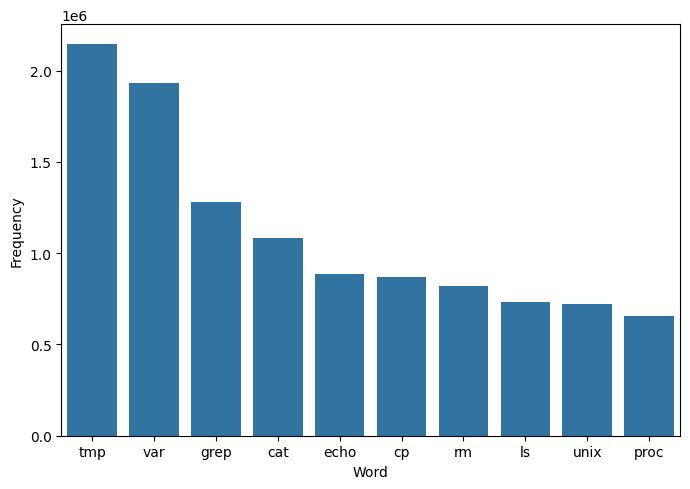

In [8]:
list_words = df["full_session"].explode()
most_common = list_words.value_counts().head(10)


plt.figure(figsize=(7,5))
sns.barplot(
    data = most_common,
)
plt.xlabel("Word")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### 1.4 Distribution of Intents

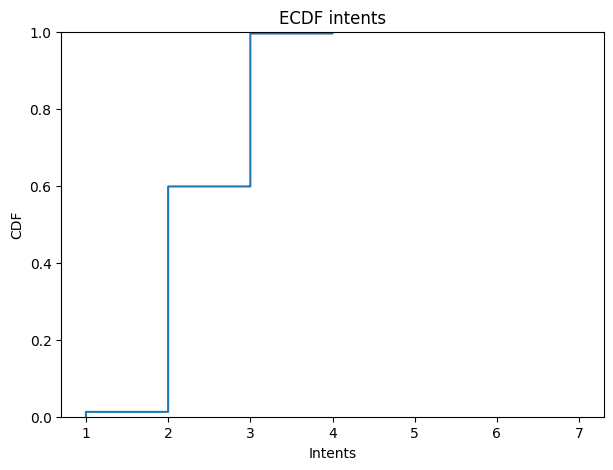

,session_id,first_timestamp,Set_Fingerprint
0,0,2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]"
1,1,2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]"
2,2,2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]"
3,3,2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]"
4,4,2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]"
...,...,...,...
233030,233042,2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]"
233031,233043,2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]"
233032,233044,2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]"
233033,233045,2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]"


In [9]:
df_intents = df[["session_id", "first_timestamp", "Set_Fingerprint"]]
# explode() is used to transform a list-like column in a DataFrame or Series into multiple rows, effectively "exploding" the list elements into separate rows.
df_intents_list = df_intents.explode('Set_Fingerprint')
intents = df_intents_list.groupby("session_id").size().to_frame("count")

plt.figure(figsize=(7,5))
sns.ecdfplot(
    data = intents,
    legend=False
)
plt.title("ECDF intents")
plt.xlabel("Intents")
plt.ylabel("CDF")
plt.show()
df_intents

Most common intents:

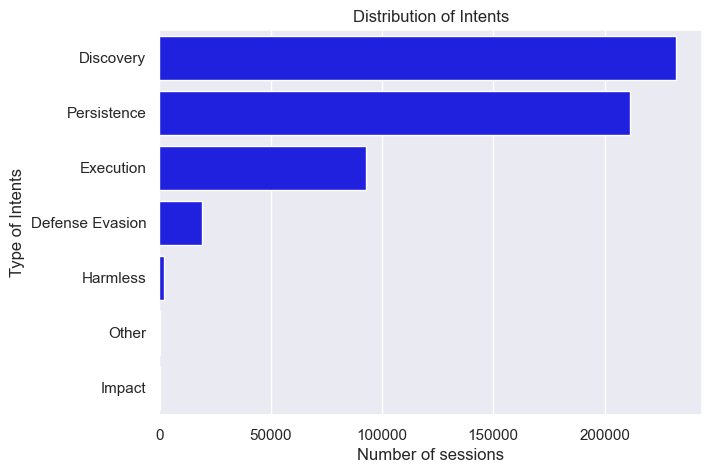

In [10]:
intents = df_intents_list.groupby('Set_Fingerprint').size().sort_values(ascending=False).to_frame("Number_of_sessions")

plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
sns.barplot(intents, x="Number_of_sessions", y=intents.index, color="blue", hue_order=intents.index)
plt.title('Distribution of Intents')
plt.xlabel('Number of sessions')
plt.ylabel('Type of Intents')

plt.show()

Distribution over tiime:

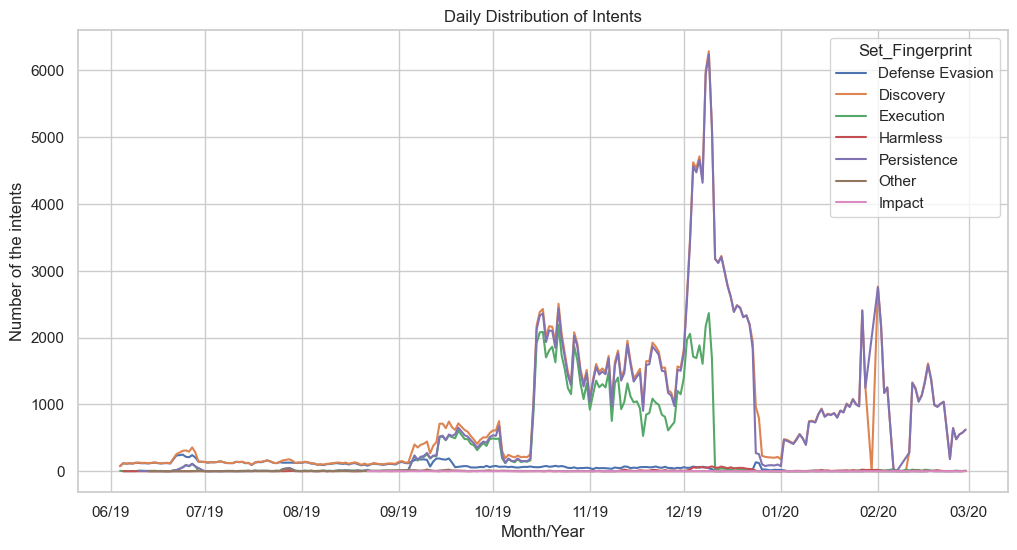

,first_timestamp,Set_Fingerprint,count
0,2019-06-04 00:00:00+00:00,Defense Evasion,80
1,2019-06-04 00:00:00+00:00,Discovery,75
2,2019-06-04 00:00:00+00:00,Execution,7
3,2019-06-05 00:00:00+00:00,Defense Evasion,120
4,2019-06-05 00:00:00+00:00,Discovery,122
...,...,...,...
1280,2020-02-29 00:00:00+00:00,Discovery,626
1281,2020-02-29 00:00:00+00:00,Execution,8
1282,2020-02-29 00:00:00+00:00,Harmless,7
1283,2020-02-29 00:00:00+00:00,Impact,1


In [11]:
df_intents_list['first_timestamp'] = pd.to_datetime(df_intents_list['first_timestamp'])
# A Grouper allows the user to specify a groupby instruction for an object.
distribution = df_intents_list.groupby([pd.Grouper(key='first_timestamp', freq='D'), 'Set_Fingerprint']).size().to_frame("count").reset_index()
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(
    data = distribution,
    x = "first_timestamp",
    y = "count",
    hue="Set_Fingerprint",
    legend=True
)
plt.title("Daily Distribution of Intents")
plt.xlabel("Month/Year")
plt.ylabel("Number of the intents")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))

plt.show()

plt.show()
distribution


### 1.5 WordCloud

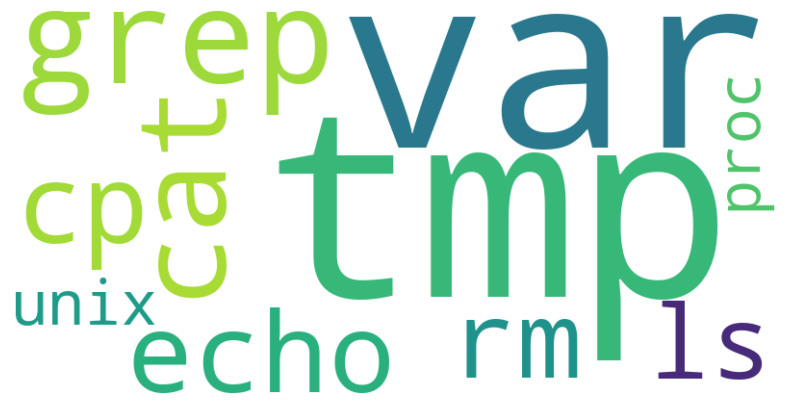

In [13]:
# Convert DataFrame to dictionary
word_freq = df_most_common_words.to_dict()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 1.5 BoW

In [9]:
# df is the version of the dataset in which the full_session is a list of words (ssh_attacks_decoded_split) 
df['session_text'] = df['full_session'].apply(lambda x: ' '.join(x)) # single string per session

# Bag of Words Transformation
vectorizer = CountVectorizer(min_df=0.05)
bow = vectorizer.fit_transform(df['session_text'])

bow_df = pd.DataFrame(bow.toarray(), columns=vectorizer.get_feature_names_out())

# Substitute the full_session column
result_df = pd.concat([df.drop(columns=['full_session', 'session_text']), bow_df], axis=1)

# Step 5: Save to parquet
result_df.to_parquet('bow_dataset.parquet', index=False)
result_df

,session_id,first_timestamp,Set_Fingerprint,awk,bash,bin,bs,busybox,cat,cd,...,tar,tftp,tmp,top,tsm,uname,unix,var,wget,which
0,0,2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]",0,0,5,1,4,3,1,...,0,1,0,0,0,0,0,0,1,0
1,1,2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]",0,0,5,1,4,3,1,...,0,1,0,0,0,0,0,0,1,0
2,2,2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]",0,0,5,1,4,3,1,...,0,1,0,0,0,0,0,0,1,0
3,3,2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]",0,0,5,1,4,3,1,...,0,1,0,0,0,0,0,0,1,0
4,4,2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]",0,0,5,1,4,3,1,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233030,233042,2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]",2,1,0,0,0,4,0,...,0,0,5,1,0,3,0,7,0,1
233031,233043,2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]",2,1,0,0,0,4,0,...,0,0,5,1,0,3,0,7,0,1
233032,233044,2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]",2,1,0,0,0,4,0,...,0,0,5,1,0,3,0,7,0,1
233033,233045,2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]",2,1,0,0,0,4,0,...,0,0,5,1,0,3,0,7,0,1


### 1.6 TF-IDF

In [17]:
import os
if not os.path.isfile("df_tfidf.parquet"):
    # Initialize the TfidfVectorizer with a min_df threshold of 0.05
    # The min_df parameter ensures that only words appearing in at least 5% of the sessions are included in the TF-IDF computation. 
    # This filters out rare words.
    vectorizer = TfidfVectorizer(min_df = 0.05)
    tfidf = vectorizer.fit_transform(df["full_session"].apply(lambda x : " ".join(x)))
    df_tfidf = pd.DataFrame(tfidf.toarray(), index=df.index, columns = list(vectorizer.vocabulary_.keys()))
    df_tfidf = pd.concat([df, df_tfidf], axis=1)
    df_features_tfidf = df_tfidf.drop(columns=["session_id", "full_session", "first_timestamp"])
    # move Set Fingerprint column as last column of the dataframe
    # df_features_tfidf.insert(len(df_features_tfidf.columns)-1, "Set_Fingerprint", df_features_tfidf.pop("Set_Fingerprint"))
    df_features_tfidf.to_parquet("df_tfidf.parquet")
else:
    df_features_tfidf = pd.read_parquet("df_tfidf.parquet")

    